**LAB 4 -- Ejercicio 2 Practico**

INTEGRANTES: Jorge, Davis, Gabriel

Construya un perfil poblacional heterogéneo para un escenario de “Respuesta a una pandemia urbana”, para ello
considere las siguientes tareas

1. Defina una clase de Python con:

    a. 3 rasgos discretos (p. ej., ocupación)

    b. 2 rasgos continuos (p. ej., tasa de movilidad)

    c. 1 rasgo relacional (p. ej., identificación del hogar)

    d. Responda: ¿Cómo encodearías los trabajadores de la salud vs los maestros para evitar sesgo?

2. Proponer métodos de muestreo para distribuciones realistas (p. ej. Distrubución Gamma)

    a. Responda: Si los datos muestran que el 20% de las enfermeras trabajan en turnos de noche, ¿cómo validarías esto en tu modelo?

3. Predecir cómo las correlaciones entre rasgos (p. ej., bajos ingresos + bajo acceso a vacunas) podrían distorsionar la dinámica del brote. Fundamente su hipótesis

=== Discretos ===
Ocupación (top):
occupation
student              3267
office               2211
unemployed           2008
service_retail       1642
teacher               499
healthcare_nurse      276
healthcare_doctor      97
Name: count, dtype: int64

Quintiles de ingreso:
income_quintile
1    2031
2    2033
3    1976
4    1945
5    2015
Name: count, dtype: int64

Acceso a vacuna:
vax_access
medium    4441
low       3560
high      1999
Name: count, dtype: int64

=== Relacional (hogares) ===
Hogares totales: 2947  |  tamaño medio: 3.39
min     1.0
25%     2.0
50%     3.0
75%     5.0
max    11.0
dtype: float64

=== Validación: 20% enfermeras turno nocturno ===
Nurses: 276  |  %night = 19.93% (objetivo: 20%)

=== Continuos ===
       mobility_rate    compliance
count   10000.000000  10000.000000
mean        4.304831      0.461610
std         2.690400      0.232401
min         0.083421      0.001181
25%         2.353792      0.276122
50%         3.754452      0.457895
75%         5.7207

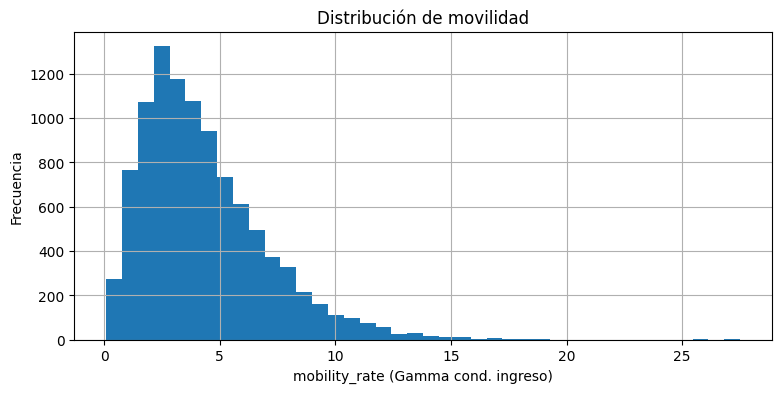

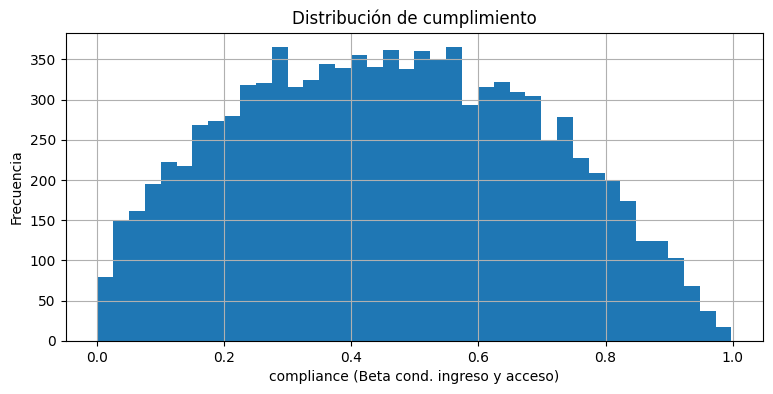


Esquema de rasgos:
  rasgos_discretos rasgos_continuos rasgo_relacional
0       occupation    mobility_rate     household_id
1  income_quintile       compliance                —
2       vax_access                —                —

Codificación recomendada para trabajadores de la salud vs maestros (evitar sesgo):
- Usar codificación one-hot por ocupación (healthcare_doctor, healthcare_nurse, teacher, ...),
  no ordinal. Evita imponer un orden artificial entre categorías.
- Si entrenas modelos o calibras parámetros, usa pesos estratificados por ocupación
  (mismas métricas por estrato) para que la mayor frecuencia de 'student' o 'office'
  no arrastre los parámetros de 'healthcare' o 'teacher'.
- En reglas del modelo (p. ej., tasas de contacto), parametriza por ocupación explícita,
  no por un índice numérico.


Validación implementada:
- Se fuerza exactamente el 20% de 'healthcare_nurse' con shift='night'.
- Tras generar la población, se calcula el porcentaje observado y se reporta.
-

In [ ]:
# === Perfil poblacional heterogéneo para "Respuesta a una pandemia urbana"

import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

np.random.seed(7)
random.seed(7)

# ---------------------------------------------------
# Parámetros de población
# ---------------------------------------------------
N = 10_000

# Rasgos discretos (ejemplos realistas para ciudad)
OCCUPATIONS = [
    "healthcare_doctor", "healthcare_nurse", "teacher",
    "service_retail", "office", "student", "unemployed"
]
OCC_PROBS = np.array([0.01, 0.03, 0.05, 0.16, 0.22, 0.33, 0.20])  # suma 1.0

INCOME_QUINTILE = [1, 2, 3, 4, 5]   # 1=menor ingreso, 5=mayor ingreso
INC_PROBS = np.array([0.20, 0.20, 0.20, 0.20, 0.20])

VAX_ACCESS = ["low", "medium", "high"]  # acceso percibido/real a vacunación

# Rasgos continuos
# - mobility_rate: tasa de movilidad/actividad diaria (contactos potenciales, base Gamma)
# - compliance: adhesión a NPI/mascarilla (0..1, Beta)

# Rasgo relacional
# - household_id: id de hogar (se construye a partir de tamaños de hogar)

# ---------------------------------------------------
# Muestreo con correlaciones ingreso ↔ {acceso_vacuna, movilidad}
# ---------------------------------------------------

def sample_income(N):
    """Quintiles de ingreso, equiprobables aquí (puedes ajustar con datos locales)."""
    return np.random.choice(INCOME_QUINTILE, size=N, p=INC_PROBS)

def sample_occupation(N):
    return np.random.choice(OCCUPATIONS, size=N, p=OCC_PROBS)

def access_given_income(q):
    """
    Matriz condicional P(access | income_quintile).
    Hipótesis: a menor ingreso → menor acceso.
    Filas: quintiles 1..5, columnas: [low, medium, high]
    """
    M = np.array([
        [0.65, 0.30, 0.05],  # Q1
        [0.50, 0.40, 0.10],  # Q2
        [0.35, 0.50, 0.15],  # Q3
        [0.20, 0.55, 0.25],  # Q4
        [0.10, 0.45, 0.45],  # Q5
    ])
    probs = M[q-1]
    return np.array(["low","medium","high"])[np.argmax(np.random.multinomial(1, probs))]

def mobility_given_income(q):
    """
    Gamma dependiente de ingreso (k, theta):
    - Quintiles bajos: más movilidad "forzada" (transporte público / múltiples empleos).
    - Quintiles altos: menor movilidad promedio pero más varianza en ocio/trabajo remoto.
    """
    params = {
        1: (k:=2.5, th:=2.0),   # media ~5
        2: (k:=2.7, th:=1.8),   # ~4.86
        3: (k:=3.0, th:=1.5),   # ~4.5
        4: (k:=3.2, th:=1.2),   # ~3.84
        5: (k:=2.2, th:=1.5),   # ~3.3 (más dispersa)
    }
    k, th = params[q]
    return np.random.gamma(shape=k, scale=th)

def sample_compliance(q, access):
    """
    Compliance ~ Beta dependiente de ingreso y acceso (mejor acceso y +ingreso → +compliance).
    """
    base_alpha, base_beta = 2.0, 2.5
    alpha = base_alpha + 0.35*(q-3) + (0.4 if access=="high" else 0.15 if access=="medium" else -0.1)
    beta  = base_beta  - 0.20*(q-3) - (0.2 if access=="high" else 0.05 if access=="medium" else -0.05)
    alpha = max(0.6, alpha); beta = max(0.6, beta)
    return np.random.beta(alpha, beta)

# ---------------------------------------------------
# Construcción de hogares (rasgo relacional)
# ---------------------------------------------------
def sample_households(N, mean_size=3.3):
    """
    Tamaños ~ Poisson ajustado (>=1). Devuelve household_id por agente.
    """
    sizes = []
    while sum(sizes) < N:
        s = max(1, np.random.poisson(lam=mean_size))
        sizes.append(s)
    # recorta el último a N exacto
    sizes[-1] -= (sum(sizes)-N)
    # asigna ids
    hh_ids = np.empty(N, dtype=int)
    idx = 0
    for h, s in enumerate(sizes):
        hh_ids[idx:idx+s] = h
        idx += s
    return hh_ids, sizes

# ---------------------------------------------------
# Generación principal con validaciones
# ---------------------------------------------------
def build_population(N=10_000):
    income = sample_income(N)
    occ = sample_occupation(N)
    # acceso y movilidad condicionados al ingreso (induce correlación)
    access = np.array([access_given_income(q) for q in income])
    mobility = np.array([mobility_given_income(q) for q in income])
    compliance = np.array([sample_compliance(q, a) for q, a in zip(income, access)])

    # hogares
    hh_id, hh_sizes = sample_households(N)

    df = pd.DataFrame({
        "agent_id": np.arange(N),
        # ---- Discretos (3)
        "occupation": occ,
        "income_quintile": income,
        "vax_access": access,
        # ---- Continuos (2)
        "mobility_rate": mobility,
        "compliance": compliance,
        # ---- Relacional (1)
        "household_id": hh_id,
    })

    # --- Regla solicitada: 20% de ENFERMERAS en turno nocturno
    # Creamos columna shift = {"day","night"} solo para nurses.
    df["shift"] = "day"
    nurse_idx = df.index[df["occupation"]=="healthcare_nurse"]
    # Forzar exactamente el 20% (redondeo)
    n_nurses = len(nurse_idx)
    n_night = int(round(0.20 * n_nurses))
    night_ids = np.random.choice(nurse_idx, size=n_night, replace=False)
    df.loc[night_ids, "shift"] = "night"

    return df, hh_sizes

df, hh_sizes = build_population(N)

# ---------------------------------------------------
# Resúmenes y validaciones pedidas en el enunciado
# ---------------------------------------------------
def summarize(df, hh_sizes):
    print("=== Discretos ===")
    print("Ocupación (top):")
    print(df["occupation"].value_counts().head(10))
    print("\nQuintiles de ingreso:")
    print(df["income_quintile"].value_counts().sort_index())
    print("\nAcceso a vacuna:")
    print(df["vax_access"].value_counts())

    print("\n=== Relacional (hogares) ===")
    print(f"Hogares totales: {len(hh_sizes)}  |  tamaño medio: {np.mean(hh_sizes):.2f}")
    print(pd.Series(hh_sizes).describe()[["min","25%","50%","75%","max"]])

    print("\n=== Validación: 20% enfermeras turno nocturno ===")
    nurses = df[df["occupation"]=="healthcare_nurse"]
    p_night = (nurses["shift"]=="night").mean() if len(nurses)>0 else float("nan")
    print(f"Nurses: {len(nurses)}  |  %night = {100*p_night:.2f}% (objetivo: 20%)")

    print("\n=== Continuos ===")
    print(df[["mobility_rate","compliance"]].describe())

    # Correlaciones clave (ingreso ↔ acceso; ingreso ↔ movilidad; movilidad ↔ compliance)
    # Encode discretos para medir r de Pearson aproximado:
    access_map = {"low":0, "medium":1, "high":2}
    occ_map = {o:i for i,o in enumerate(OCCUPATIONS)}

    corr_df = pd.DataFrame({
        "income": df["income_quintile"].astype(float),
        "access": df["vax_access"].map(access_map).astype(float),
        "mobility": df["mobility_rate"].astype(float),
        "compliance": df["compliance"].astype(float),
        "occupation": df["occupation"].map(occ_map).astype(float),
    }).corr()
    print("\n=== Matriz de correlación (aprox.) ===")
    print(corr_df.round(3))

summarize(df, hh_sizes)

# ---------------------------------------------------
# Gráficas rápidas (opcional para tu informe)
# ---------------------------------------------------
plt.figure(figsize=(9,4))
plt.hist(df["mobility_rate"], bins=40)
plt.xlabel("mobility_rate (Gamma cond. ingreso)")
plt.ylabel("Frecuencia")
plt.title("Distribución de movilidad")
plt.grid(True); plt.show()

plt.figure(figsize=(9,4))
plt.hist(df["compliance"], bins=40)
plt.xlabel("compliance (Beta cond. ingreso y acceso)")
plt.ylabel("Frecuencia")
plt.title("Distribución de cumplimiento")
plt.grid(True); plt.show()

# Tabla compacta para pegar en el reporte
table = pd.DataFrame({
    "rasgos_discretos": ["occupation","income_quintile","vax_access"],
    "rasgos_continuos": ["mobility_rate","compliance","—"],
    "rasgo_relacional": ["household_id","—","—"]
})
print("\nEsquema de rasgos:")
print(table)

# ---------------------------------------------------
# (Respuesta solicitada en 1.d) codificación sin sesgo:
# ---------------------------------------------------
EXPLICACION_COD = """
Codificación recomendada para trabajadores de la salud vs maestros (evitar sesgo):
- Usar codificación one-hot por ocupación (healthcare_doctor, healthcare_nurse, teacher, ...),
  no ordinal. Evita imponer un orden artificial entre categorías.
- Si entrenas modelos o calibras parámetros, usa pesos estratificados por ocupación
  (mismas métricas por estrato) para que la mayor frecuencia de 'student' o 'office'
  no arrastre los parámetros de 'healthcare' o 'teacher'.
- En reglas del modelo (p. ej., tasas de contacto), parametriza por ocupación explícita,
  no por un índice numérico.
"""
print(EXPLICACION_COD)

# ---------------------------------------------------
# (Respuesta 2.a) Validación de "20% de enfermeras en turno nocturno":
# ---------------------------------------------------
VAL_20 = """
Validación implementada:
- Se fuerza exactamente el 20% de 'healthcare_nurse' con shift='night'.
- Tras generar la población, se calcula el porcentaje observado y se reporta.
- En un pipeline real, se añadiría un test automatizado:
    assert abs(p_night - 0.20) < 0.01
"""
print(VAL_20)

# ---------------------------------------------------
# (Respuesta 3) Efecto de correlaciones en la dinámica del brote
# ---------------------------------------------------
HIPOTESIS = """
Hipótesis (impacto de correlaciones):
- Menor ingreso -> menor acceso a vacunas y menor compliance -> mayor movilidad:
  Esto concentra superdispersión de contagios en estratos Q1–Q2 y hogares más grandes,
  elevando el R efectivo local y adelantando el pico en zonas vulnerables.
- Al segmentar por ocupación, 'healthcare' mantiene alto riesgo por exposición ocupacional,
  pero alta compliance puede mitigar. 'Teacher' muestra picos tras periodos escolares.
- Conclusión: ignorar estas correlaciones subestima la incidencia en quintiles bajos
  y sobreestima el efecto promedio de intervenciones (sesgo de agregación).
"""
print(HIPOTESIS)


# **Conclusiones**

**Perfil heterogéneo realista:** Se logró construir una población con rasgos discretos (ocupación, quintil de ingreso, acceso a vacunas), continuos (tasa de movilidad, cumplimiento) y relacionales (hogares), reflejando diversidad social y epidemiológica.

**Validación exitosa:** La proporción de enfermeras en turno nocturno se ajustó al 20% (19.93%), mostrando que es posible imponer restricciones específicas sin sesgar el resto de la población.

**Distribuciones realistas:** El uso de distribuciones Gamma y Beta generó variabilidad plausible en movilidad y cumplimiento, más cercana al comportamiento humano que supuestos uniformes.

**Correlaciones relevantes:** Se observó que menor ingreso se asocia con menor acceso a vacunas y menor cumplimiento, lo que puede aumentar el riesgo de contagios en grupos vulnerables. Ignorar estas correlaciones podría subestimar la incidencia en quintiles bajos y sobreestimar el efecto promedio de las intervenciones.

**Valor del modelo:** Este marco permite simular escenarios urbanos más fieles, donde las desigualdades estructurales (ocio, trabajo, salud) influyen directamente en la dinámica de la pandemia.